# Frame the problem and look at the big picture
This is exercise #4 from Chapter 3 of Hands-On Machine Learning, which covers classification. 

1. __Define the objective.__ The task is to build a spam classifier using data from [Apache SpamAssassin's public datasets](https://spamassassin.apache.org/old/publiccorpus/) ([README](https://spamassassin.apache.org/old/publiccorpus/readme.html)). 

2. __How will your solution be used?__ This could be used by an email service like Gmail to automatically flag and filter out messages that have a high probability of being spam. 

3. __What are the current solutions/workarounds (if any)?__ Well, spam filters do already exist in most if not all email services. That being said, some spam emails still get through, so it's up to users to identify those on their own. In addition, when a spam email does get through, users can mark it as spam, and all future emails from that address will be automatically marked as spam. 

4. __How should you frame this problem (supervised/unsupervised, online/offline, etc.)?__ This is a __supervised classification task__ because we are making binary predictions (spam vs. ham) and we have labeled training data. Ideally, this is an online learning task, because spammers never stop thinking of new ways to trick people, so the model should be learning from new data constantly. However, for the sake of this exercise, it will be an offline system using static training data. 

5. __How should performance be measured?__ This is a bit more complex than the Titanic task, for example, where _accuracy_ was our primary performance metric. Is it better to lean further towards spam and risk misclassifying safe emails as spam? Or is it better to lean further towards "ham" and risk missing spam emails?
    - According to ChatGPT: "For a spam classifier, it is generally more fitting to __prioritize precision over recall__." This is because a spam classifier that marks safe emails as spam is a real nuisance to users, whereas missing a few spam emails is not as big a deal. By focusing on precision, we will minimize false positives and reduce the chances of misclassifying safe emails. 
    
    - `Precision = TP / (TP + FP)`
    
    - That being said, __there should also be a minimum recall.__ I could predict just one instance as spam, and if I'm correct, that means my precision is 100%. However, recall would be way too low.  
    
6. __Is the performance measure aligned with the business objective?__ Yes. Optimizing for precision will reduce the number of false positives, and therefore create a better hypothetical user experience. Since the spam classifier would most likely be used in a commercial product, user experience is the most important thing. 

7. __What would be the minimum performance needed to reach the business objective?__ It seems that a __precision of 95%__ is the widely recommended benchmark for spam classifiers. Regarding minimum recall, maybe let's see baseline performance of different models to estimate what a realistic minimum might be. 

8. __What are comparable problems? Can you reuse experience or tools?__ Beyond the Titanic dataset, this is really my first end-to-end classification project. From my work on the [MNIST dataset](https://github.com/iherman10/mnist-classification/blob/main/chapter_3.ipynb), I can reuse some charting function to analyze performance and compare models. From my work on the [Titanic dataset](https://github.com/iherman10/titanic/blob/main/titanic_2.ipynb), I can reuse the custom transformer class structures for data transformation purposes.

9. __Is human expertise available?__ The internet :) I'm working on this solo. 

10. __How would you solve the problem manually?__ When I try to eyeball whether an email is spam or not, I consider:
    - Have I received emails from this sender before?
    - Are there obvious typos?
    - Are there links? 
    - Are they asking for money? Or credit card information? Etc. 
    - Are they writing in all caps? Or all lower-case? 
    
    These considerations might influence the feature engineering part of this project. 

11. __List assumptions you've made so far.__ 
    - I should be able to identify most spam just by looking at it. 
    
    - I'll have to leverage text transformations to process the data. 
    
    - Baseline models should get me most of the way towards my performance goal, and feature engineering/hyperparameter tuning will get me the rest of the way.  

12. __Verify assumptions if possible.__ TBD...

In [1]:
# Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import os
import tarfile 
import urllib.request

import joblib

import email 
import email.policy

from collections import Counter

from sklearn.model_selection import train_test_split

from html import unescape
from bs4 import BeautifulSoup
import re 
import html
import nltk

# Use % to install in currently running environment, not ! 
%pip install urlextract
import urlextract

from sklearn.base import BaseEstimator, TransformerMixin

from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Looking in indexes: https://artifacts-prod-use1.pinadmin.com/artifactory/api/pypi/pinterest-python-pip-prod-virtual/simple/
Note: you may need to restart the kernel to use updated packages.


# Get the data
Available data from SpamAssassin website: 
- `spam`: 500 spam messages 
- `spam_2`: 1396 spam messages, added more recently. 
- `easy_ham`: 2500 non-spam messages, fairly easy to differentiate.  
- `easy_ham_2`: 144 non-spam messages, added more recently. 
- `hard_ham`: 250 non-spam messages, harder to differentiate. 

In total, there are __6046__ messages with about a 31% spam ratio. 

In [2]:
# Download data 
DOWNLOAD_ROOT = 'http://spamassassin.apache.org/old/publiccorpus/'

SPAM_URL = DOWNLOAD_ROOT + '20030228_spam.tar.bz2'
SPAM_2_URL = DOWNLOAD_ROOT + '20050311_spam_2.tar.bz2'
EASY_HAM_URL = DOWNLOAD_ROOT + '20030228_easy_ham.tar.bz2'
EASY_HAM_2_URL = DOWNLOAD_ROOT + '20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = DOWNLOAD_ROOT + '20030228_hard_ham.tar.bz2'

SPAM_PATH = os.path.join('datasets', 'spam')

def fetch_spam_data(spam_url=SPAM_URL, 
                    spam_2_url=SPAM_2_URL, 
                    easy_ham_url=EASY_HAM_URL, 
                    easy_ham_2_url=EASY_HAM_2_URL, 
                    hard_ham_url=HARD_HAM_URL,  
                    spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (('spam.tar.bz2', SPAM_URL), 
                          ('spam_2.tar.bz2', SPAM_2_URL), 
                          ('easy_ham.tar.bz2', EASY_HAM_URL), 
                          ('easy_ham_2.tar.bz2', EASY_HAM_2_URL), 
                          ('hard_ham.tar.bz2', HARD_HAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [3]:
fetch_spam_data()

In [4]:
# Load all the emails 
SPAM_DIR = os.path.join(SPAM_PATH, 'spam')
SPAM_2_DIR = os.path.join(SPAM_PATH, 'spam_2')
EASY_HAM_DIR = os.path.join(SPAM_PATH, 'easy_ham')
EASY_HAM_2_DIR = os.path.join(SPAM_PATH, 'easy_ham_2')
HARD_HAM_DIR = os.path.join(SPAM_PATH, 'hard_ham')

spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]
spam_2_filenames = [name for name in sorted(os.listdir(SPAM_2_DIR)) if len(name) > 20]
easy_ham_filenames = [name for name in sorted(os.listdir(EASY_HAM_DIR)) if len(name) > 20]
easy_ham_2_filenames = [name for name in sorted(os.listdir(EASY_HAM_2_DIR)) if len(name) > 20]
hard_ham_filenames = [name for name in sorted(os.listdir(HARD_HAM_DIR)) if len(name) > 20]

In [5]:
print(f"""
spam: {len(spam_filenames)} files
spam_2: {len(spam_2_filenames)} files
easy_ham: {len(easy_ham_filenames)} files
easy_ham_2: {len(easy_ham_2_filenames)} files 
hard_ham: {len(hard_ham_filenames)} files 
""")


spam: 500 files
spam_2: 1396 files
easy_ham: 2500 files
easy_ham_2: 1400 files 
hard_ham: 250 files 



In [6]:
# Parse emails 
def load_email(directory, filename, spam_path=SPAM_PATH):
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
spam_emails = [load_email(directory='spam', filename=name) for name in spam_filenames]
spam_2_emails = [load_email(directory='spam_2', filename=name) for name in spam_2_filenames]
easy_ham_emails = [load_email(directory='easy_ham', filename=name) for name in easy_ham_filenames]
easy_ham_2_emails = [load_email(directory='easy_ham_2', filename=name) for name in easy_ham_2_filenames]
hard_ham_emails = [load_email(directory='hard_ham', filename=name) for name in hard_ham_filenames]

In [7]:
# Create train and test sets 
X = np.array(spam_emails \
             + spam_2_emails \
             + easy_ham_emails \
             + easy_ham_2_emails \
             + hard_ham_emails \
             , dtype=object)

y = np.array([1] * len(spam_emails) \
             + [1] * len(spam_2_emails) \
             + [0] * len(easy_ham_emails) \
             + [0] * len(easy_ham_2_emails) \
             + [0] * len(hard_ham_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Explore the data
Let's start by examining examples of ham vs. spam to understand what the data looks like.

In [8]:
# Ham
print(easy_ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [9]:
# Spam
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are multipart, with images and attachments. Let's look at different types of structures. 

In [10]:
def get_email_structure(email):
    if isinstance(email, str):
        return email 
    payload = email.get_payload()
    if isinstance(payload, list):
        return f'multipart({", ".join([get_email_structure(sub_email) for sub_email in payload])})'
    else:
        return email.get_content_type()

In [11]:
def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [12]:
structures_counter(easy_ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [13]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that ham emails are more often plan text, while spam has a lot of html. Also, a lot of ham emails are signed using "pgp", while no spam is. Email structure might be an important feature. 

In [14]:
# Examine email headers 
for header, value in spam_emails[0].items():
    print(header, ':', value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [15]:
# Just look at the Subject header
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

## Email to text transformations
The emails are easiest to work with in plain text format. We need some functions to transform emails. 

In [16]:
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [17]:
html_spam_emails = [email for email in X_train[y_train==1] if get_email_structure(email) == 'text/html']
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<html>

<body>

<font size="2" PTSIZE="10">
<table height="338" cellSpacing="0" cellPadding="0" width="539" border="0" style="border:12px double #006600; border-collapse:collapse; padding-left:4; padding-right:4; padding-top:1; padding-bottom:1" bordercolor="#111111" bordercolorlight="#FFFFFF" bordercolordark="#FFFFFF">
  <tr>
    <td width="4" height="423">&nbsp;</td>
    <td vAlign="top" align="left" width="535" height="423" style="border-style: solid; border-width: 0">
    <table cellSpacing="0" cellPadding="4" width="95%" border="0" bgcolor="#FFFFFF" style="border-collapse: collapse" bordercolor="#111111">
      <tr>
        <td vAlign="top" align="right" height="424">
        <table cellSpacing="0" cellPadding="0" width="100%" border="0">
          <tr>
            <td>
            <div align="left">
              <font face="Verdana, Arial, Helvetica, sans-serif" size="2"><b>
              <font face="Verdana, Arial, Helvetica, sans-serif" color="#000000" size="2">
              

In [18]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


     
              Dear
              Homeowner,
 
              *6.25%
              30 Yr Fixed Rate Mortgage
              Interest
              rates are at their lowest point in 40 years! We help you find the
              best rate for your situation by matching your needs with hundreds
              of lenders! Home Improvement, Refinance, Second
              Mortgage, Home Equity Loans, and More! Even with less
              than perfect credit!
               HYPERLINK Click Here for a Free Quote! HYPERLINK
            Lock
            In YOUR LOW FIXED RATE TODAY
              aNO
              COST OUT OF POCKET
              aNO
              OBLIGATION
              aFREE
              CONSULTATION
              aALL
              CREDIT GRADES ACCEPTED
               HYPERLINK Rates as low as
              6.25% won't stay this low forever CLICK HERE
               
              * based on mortgage rate as of 5-15-02 as low as 6.25% see lender
              for detai

In [19]:
# Function to convert entire email to plaintext, regardless of format
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [20]:
print(email_to_text(sample_html_spam)[:1000], "...")


     
              Dear
              Homeowner,
 
              *6.25%
              30 Yr Fixed Rate Mortgage
              Interest
              rates are at their lowest point in 40 years! We help you find the
              best rate for your situation by matching your needs with hundreds
              of lenders! Home Improvement, Refinance, Second
              Mortgage, Home Equity Loans, and More! Even with less
              than perfect credit!
               HYPERLINK Click Here for a Free Quote! HYPERLINK
            Lock
            In YOUR LOW FIXED RATE TODAY
              aNO
              COST OUT OF POCKET
              aNO
              OBLIGATION
              aFREE
              CONSULTATION
              aALL
              CREDIT GRADES ACCEPTED
               HYPERLINK Rates as low as
              6.25% won't stay this low forever CLICK HERE
               
              * based on mortgage rate as of 5-15-02 as low as 6.25% see lender
              for detai

## Stemming
Stemming is the process of reducing inflected (or derived) words to their word stem/base/root. E.g. _cat_ from _cats/catlike/catty_. 

We can use the Natural Language Toolkit ([NLTK](https://www.nltk.org/)) to do this.

In [21]:
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, '=>', stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


## Finding URLs
We want to replace URLs with the word "URL". We can use the the `urlextract` library to do this intead of regular expressions.

In [22]:
url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


# Prepare the data
Let's create custom transformer classes to implement the transformations we tested above. Ultimately, the goal is to convert each email into a sparse vector that indicates the presence or absence of each possible word. 

In [23]:
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [24]:
# Test on a few emails 
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'it': 8, 'number': 6, 'no': 6, 'i': 4, 'new': 4, 'a': 3, 'for': 3, 'don': 3, 't': 3, 'url': 2, 'think': 2, 'about': 2, 'not': 2, 'out': 2, 'next': 2, 'if': 2, 'said': 2, 'stop': 2, 'do': 2, 'even': 2, 'date': 1, 'numbertnumb': 1, 'am': 1, 'get': 1, 'mac': 1, 'ani': 1, 'good': 1, 'reason': 1, 'though': 1, 'll': 1, 'tri': 1, 'to': 1, 'wait': 1, 'one': 1, 'of': 1, 'the': 1, 'ibook': 1, 'rumor': 1, 'spring': 1, 'powerbook': 1, 'month': 1, 'model': 1, 'come': 1, 's': 1, 'realli': 1, 'bad': 1, 'idea': 1, 'geez': 1, 'ha': 1, 'an': 1, 'cooler': 1, 'monitor': 1, 'or': 1}),
       Counter({'to': 11, 'the': 9, 'number': 6, 'market': 5, 'asset': 4, 'thi': 4, 'we': 4, 'mail': 4, 'system': 3, 'is': 3, 'in': 3, 'agent': 3, 'do': 3, 'at': 3, 'our': 3, 'jennif': 3, 'url': 3, 'not': 3, 'insur': 2, 'industri': 2, 's': 2, 'year': 2, 'll': 2, 'high': 2, 'america': 2, 'qualifi': 2, 'you': 2, 'for': 2, 'phone': 2, 'call': 2, 'or': 2, 'e': 2, 'assetmarketingsystem': 2, 'com': 2, 'profession': 

We need to convert our word counts to vectors. To do this, we'll build another transformer:
- `fit()`: build the vocabulary (ordered list of the most common words)
- `transform()`: use the vocabulary to convert word counts to vectors (sparse matrix)

In [25]:
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [26]:
vocab_transfomer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transfomer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [27]:
X_few_vectors.toarray()

array([[ 60,   6,   1,   1,   8,   6,   3,   2,   4,   2,   2],
       [178,   6,  11,   9,   0,   1,   2,   3,   0,   3,   3],
       [ 23,   0,   1,   0,   0,   0,   1,   0,   1,   0,   0]])

How to interpret this matrix: the 178 in the second row, first column, means that the second email contains 178 words that are not part of the vocabulary. The 6 next to it means that the first word in the vocabulary is present 6 times in this email. The 11 next to it means that the second word is present 11 times, and so on. You can look at the vocabulary to know which words we are talking about. 

In [28]:
vocab_transfomer.vocabulary_

{'number': 1,
 'to': 2,
 'the': 3,
 'it': 4,
 'no': 5,
 'for': 6,
 'url': 7,
 'i': 8,
 'not': 9,
 'do': 10}

In [29]:
# Create full pipeline 
preprocess_pipeline = Pipeline([
    ('email_to_wordcount', EmailToWordCounterTransformer()), 
    ('wordcount_to_vector', WordCounterToVectorTransformer())
])

path = 'arrays/x_train_transformed.npz'
if not os.path.exists(path):
    X_train_transformed = preprocess_pipeline.fit_transform(X_train)
    save_npz(path, X_train_transformed)
else: 
    X_train_transformed = load_npz(path)

# Shortlist promising models
- Logistic Regression
- K-Nearest Neighbors
- Support Vector Machines (SVM)
- Random Forest 
- Gradient Boosting 
- AdaBoost
- Naive Bayes
- Decision Tree

For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds. 

In [31]:
# Libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.naive_bayes import GaussianNB  

In [32]:
# Utility functions 
score_dict = {}
def print_scores(scores, name):
    print(f"""
    {name} precision mean: {scores.mean()}
    {name} precision std deviation: {scores.std()}
    """)
    
def test_model(model, path, name):
    if not os.path.exists(f'arrays/{path}_cross_val_score.npy'):
        if name == 'Gaussian Naive Bayes':  
            scores = cross_val_score(model, X_train_transformed.toarray(), y_train, cv=3, verbose=3, scoring='precision') 
        else:  
            scores = cross_val_score(model, X_train_transformed, y_train, cv=3, verbose=3, scoring='precision') 
        np.save(f'arrays/{path}_cross_val_score.npy', scores)
    else: 
        scores = np.load(f'arrays/{path}_cross_val_score.npy')
    score_dict[name] = (scores.mean(), scores.std())
    print_scores(scores, name)

In [33]:
# Logistic Regression 
logreg_clf = LogisticRegression(max_iter=1000)
test_model(logreg_clf, 'logreg_clf', 'Logistic Regression')


    Logistic Regression precision mean: 0.9626448261008299
    Logistic Regression precision std deviation: 0.0093574850865649
    


In [34]:
# KNN
knn_clf = KNeighborsClassifier()
test_model(knn_clf, 'knn_clf', 'KNN')


    KNN precision mean: 0.9214689750413562
    KNN precision std deviation: 0.025142727468775793
    


In [35]:
# SVC 
svc_clf = SVC()
test_model(svc_clf, 'svc_clf', 'SVC')


    SVC precision mean: 0.926626889015365
    SVC precision std deviation: 0.01372424229282667
    


In [36]:
# Decision Tree
tree_clf = DecisionTreeClassifier()
test_model(tree_clf, 'tree_clf', 'Decision Tree')


    Decision Tree precision mean: 0.8961261901818807
    Decision Tree precision std deviation: 0.004823346032105514
    


In [37]:
# Random Forest
forest_clf = RandomForestClassifier()
test_model(forest_clf, 'forest_clf', 'Random Forest')


    Random Forest precision mean: 0.9723023914414596
    Random Forest precision std deviation: 0.005323107883871503
    


In [38]:
# Gradient Boosting
gb_clf = GradientBoostingClassifier()
test_model(gb_clf, 'gb_clf', 'Gradient Boosting')


    Gradient Boosting precision mean: 0.9675640193446898
    Gradient Boosting precision std deviation: 0.007369205326750911
    


In [39]:
# AdaBoost
ab_clf = AdaBoostClassifier()
test_model(ab_clf, 'ab_clf', 'AdaBoost')


    AdaBoost precision mean: 0.9579809857983962
    AdaBoost precision std deviation: 0.008378059991044972
    


In [40]:
gnb_clf = GaussianNB()
test_model(gnb_clf, 'gnb_clf', 'Gaussian Naive Bayes')


    Gaussian Naive Bayes precision mean: 0.8407429108531389
    Gaussian Naive Bayes precision std deviation: 0.08412909839522416
    


In [41]:
score_dict

{'Logistic Regression': (0.9626448261008299, 0.0093574850865649),
 'KNN': (0.9214689750413562, 0.025142727468775793),
 'SVC': (0.926626889015365, 0.01372424229282667),
 'Decision Tree': (0.8961261901818807, 0.004823346032105514),
 'Random Forest': (0.9723023914414596, 0.005323107883871503),
 'Gradient Boosting': (0.9675640193446898, 0.007369205326750911),
 'AdaBoost': (0.9579809857983962, 0.008378059991044972),
 'Gaussian Naive Bayes': (0.8407429108531389, 0.08412909839522416)}

<Axes: title={'center': 'Model Precision'}>

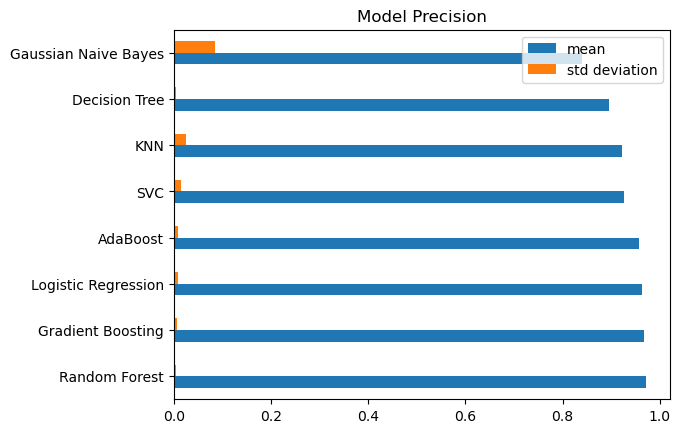

In [42]:
score_df = pd.DataFrame.from_dict(score_dict, 
                                  orient='index', 
                                  columns=['mean', 'std deviation']) \
                                .sort_values('mean', ascending=False)
score_df.plot(kind='barh', title='Model Precision')

In [43]:
score_df

,mean,std deviation
Random Forest,0.972302,0.005323
Gradient Boosting,0.967564,0.007369
Logistic Regression,0.962645,0.009357
AdaBoost,0.957981,0.008378
SVC,0.926627,0.013724
KNN,0.921469,0.025143
Decision Tree,0.896126,0.004823
Gaussian Naive Bayes,0.840743,0.084129


# Fine-tune the system
Fine-tune the hyperparameters using cross-validation, preferring random search over grid search (unless there are very vew hyperparameter values to explore). 

Let's pick the top three models with the highest precision:
1. Random Forest
2. Gradient Boosting
3. Logistic Regression

In [57]:
# Utility function 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal

def train_model_search(search_object, path):
    if not os.path.exists(f'models/{path}.joblib'):
        search_object.fit(X_train_transformed, y_train)
        joblib.dump(search_object, f'models/{path}.joblib')
        
    else:
        search_object = joblib.load(f'models/{path}.joblib')
        
    return search_object

In [58]:
# Random Forest
param_grid = {  
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 5, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['log2', 'sqrt'],  
    'bootstrap': [True, False]  
}  
forest_clf = RandomForestClassifier()
forest_grid_search = GridSearchCV(
    forest_clf, 
    param_grid, 
    cv=3, 
    scoring='precision', 
    verbose=3
)

forest_grid_search = train_model_search(forest_grid_search, 'forest_clf')
forest_grid_search.best_estimator_

RandomForestClassifier(max_depth=3, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10)

In [60]:
# Gradient boosting
param_grid = {  
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.1, 1],  
    'max_depth': [3, 5, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['log2', 'sqrt']  
}  
gb_clf = GradientBoostingClasslogreg_clfb_grid_search = GridSearchCV(
    gb_clf, 
    param_grid, 
    cv=3, 
    scoring='precision', 
    verbose=3
)
gb_grid_search = train_model_search(gb_grid_search, 'gb_clf')
gb_grid_search.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=1.000 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.986 total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.991 total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.986 total time=   0.3s


GradientBoostingClassifier(learning_rate=0.01, max_features='log2')

In [64]:
# Logistic regression
param_grid = {  
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'C': [0.1, 1, 10],  
    'fit_intercept': [True, False],  
    'solver': ['liblinear', 'saga']
}  
logreg_clf = LogisticRegression(max_iter=1000)
logreg_grid_search = GridSearchCV(
    logreg_clf, 
    param_grid, 
    cv=3, 
    scoring='precision', 
    verbose=3
)
logreg_grid_search = train_model_search(logreg_grid_search, 'logreg_clf')
logreg_grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END C=0.1, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.968 total time=   0.2s
[CV 2/3] END C=0.1, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.962 total time=   0.2s
[CV 3/3] END C=0.1, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.954 total time=   0.1s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, penalty=l1, solver=saga;, score=0.923 total time=  12.3s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, penalty=l1, solver=saga;, score=0.923 total time=  14.3s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, penalty=l1, solver=saga;, score=0.916 total time=  14.2s
[CV 1/3] END C=0.1, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.975 total time=   0.3s
[CV 2/3] END C=0.1, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.965 total time=   0.4s
[CV 3/3] END C=0.1, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.973 total time=   0.2s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=True, penalty=l2, solver=saga;, score=0.930 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=True, penalty=l2, solver=saga;, score=0.923 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=True, penalty=l2, solver=saga;, score=0.921 total time=   1.5s
[CV 1/3] END C=0.1, fit_intercept=True, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=True, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=True, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=True, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, penalty=l1, solver=liblinear;, score=0.960 total time=   0.2s
[CV 2/3] END C=0.1, fit_intercept=False, penalty=l1, solver=liblinear;, score=0.949 total time=   0.2s
[CV 3/3] END C=0.1, fit_intercept=False, penalty=l1, solver=libl

/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, penalty=l1, solver=saga;, score=0.923 total time=  12.4s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=False, penalty=l1, solver=saga;, score=0.923 total time=  14.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, penalty=l1, solver=saga;, score=0.916 total time=  14.2s
[CV 1/3] END C=0.1, fit_intercept=False, penalty=l2, solver=liblinear;, score=0.969 total time=   0.2s
[CV 2/3] END C=0.1, fit_intercept=False, penalty=l2, solver=liblinear;, score=0.958 total time=   0.3s
[CV 3/3] END C=0.1, fit_intercept=False, penalty=l2, solver=liblinear;, score=0.971 total time=   0.3s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, fit_intercept=False, penalty=l2, solver=saga;, score=0.930 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, fit_intercept=False, penalty=l2, solver=saga;, score=0.923 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, fit_intercept=False, penalty=l2, solver=saga;, score=0.921 total time=   1.5s
[CV 1/3] END C=0.1, fit_intercept=False, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, fit_intercept=False, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, fit_intercept=False, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/3] END C=0.1, fit_intercept=False, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.961 total time=   0.3s
[CV 2/3] END C=1, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.948 total time=   0.2s
[CV 3/3] END C=1, fit_intercept=True, penalty=l1, solver=liblin

/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, penalty=l1, solver=saga;, score=0.930 total time=  19.1s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, penalty=l1, solver=saga;, score=0.923 total time=  18.4s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, penalty=l1, solver=saga;, score=0.921 total time=  18.7s
[CV 1/3] END C=1, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.969 total time=   0.6s
[CV 2/3] END C=1, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.949 total time=   0.7s
[CV 3/3] END C=1, fit_intercept=True, penalty=l2, solver=liblinear;, score=0.972 total time=   0.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=True, penalty=l2, solver=saga;, score=0.930 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=True, penalty=l2, solver=saga;, score=0.923 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=True, penalty=l2, solver=saga;, score=0.921 total time=   1.5s
[CV 1/3] END C=1, fit_intercept=True, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, fit_intercept=True, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/3] END C=1, fit_intercept=True, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/3] END C=1, fit_intercept=True, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, penalty=l1, solver=liblinear;, score=0.959 total time=   0.2s
[CV 2/3] END C=1, fit_intercept=False, penalty=l1, solver=liblinear;, score=0.948 total time=   0.2s
[CV 3/3] END C=1, fit_intercept=False, penalty=l1, solver=liblinear;, score=0.963 

/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, penalty=l1, solver=saga;, score=0.930 total time=  18.2s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, penalty=l1, solver=saga;, score=0.923 total time=  18.3s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, penalty=l1, solver=saga;, score=0.921 total time=  18.5s
[CV 1/3] END C=1, fit_intercept=False, penalty=l2, solver=liblinear;, score=0.969 total time=   0.5s
[CV 2/3] END C=1, fit_intercept=False, penalty=l2, solver=liblinear;, score=0.949 total time=   0.7s
[CV 3/3] END C=1, fit_intercept=False, penalty=l2, solver=liblinear;, score=0.971 total time=   0.6s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, fit_intercept=False, penalty=l2, solver=saga;, score=0.930 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, fit_intercept=False, penalty=l2, solver=saga;, score=0.924 total time=   1.5s


/Users/iherman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, fit_intercept=False, penalty=l2, solver=saga;, score=0.921 total time=   1.5s
[CV 1/3] END C=1, fit_intercept=False, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=1, fit_intercept=False, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/3] END C=1, fit_intercept=False, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/3] END C=1, fit_intercept=False, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/3] END C=10, fit_intercept=True, penalty=l1, solver=liblinear;, score=0.936 total time=   0.3s


KeyboardInterrupt: 

# Present your solution